# Predicting Education Level

## Introduction

At some point in our lives we must decide on how to make a living. People wish to find a path that leads to the most success without using too many resources, and one of the main problems to that is education. The decision to pursue a higher education is both time and money-consuming, which is why our Data Science project question is: "Can we predict the highest level of education someone has received based on their salary, years of experience, and age?"

The dataset we are using contains 7 columns reading left to right: `Education`, `Experience`, `Location`, `Job_Title`, `Age`, `Gender`, `Salary`, where each row represents an individual worker.

- `Education`: four categories representing the highest level of education received: High School, Bachelor, Master, PhD
- `Experience`: years of professional experience
- `Location`: three locations of work: Urban, Suburban, Rural
- `Job_Title`: four general job titles: Manager, Director, Analyst, Engineer
- `Age`: age
- `Gender`: Female or Male
- `Salary`: annual salary

## Data analysis

In [1]:
# Load in the libraries needed to read the csv file
library(tidyverse)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# Load the csv file into a data frame
# Dataset website: https://www.kaggle.com/datasets/mrsimple07/salary-prediction-data
download.file("https://raw.githubusercontent.com/WhenLifeHandsYouLemons/UBC-DSCI-100-Project/main/data/salary_prediction_data.csv", "data/salary_prediction_data.csv")

df_untidy <- read_csv("data/salary_prediction_data.csv")
head(df_untidy)

Rows: 1000 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, Location, Job_Title, Gender
dbl (3): Experience, Age, Salary

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,Experience,Location,Job_Title,Age,Gender,Salary
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
High School,8,Urban,Manager,63,Male,84620.05
PhD,11,Suburban,Director,59,Male,142591.26
Bachelor,28,Suburban,Manager,61,Female,97800.26
High School,29,Rural,Director,45,Male,96834.67
PhD,25,Urban,Analyst,26,Female,132157.79
PhD,19,Rural,Director,27,Female,156312.94


In [39]:
# Rename all the columns to include the units and be in lowercase
# Then select the newly mutated columns only
df_tidy <- df_untidy |>
    mutate(education = Education, experience_years = Experience, salary_dollars = Salary) |>
    select(salary_dollars, education, experience_years) |>
    mutate(salary_dollars = round(salary_dollars, 2)) |>
    mutate(education = as_factor(education))

head(df_tidy)

salary_dollars,education,experience_years
<dbl>,<fct>,<dbl>
84620.05,High School,8
142591.26,PhD,11
97800.26,Bachelor,28
96834.67,High School,29
132157.79,PhD,25
156312.94,PhD,19


- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.

In [40]:
# Load library for spliting data into training and testing
library(tidymodels)

In [41]:
# Set the seed for this code cell
set.seed(1)

# Split data into a rough 75-25 split
df_split <- initial_split(df_tidy, 0.75, education)
df_train <- training(df_split)
df_testing <- testing(df_split)

# Summarise the average values for each of our predictor classes
df_summary_1 <- df_train |>
    summarise(average_experience_years = round(mean(experience_years, na.rm=TRUE)),
              average_salary_dollars = round(mean(salary_dollars, na.rm=TRUE), 2))

# Summarise the total observations in each predictor class
df_summary_2 <- df_train |>
    summarise(total_observations = length(experience_years))

# There are no observations with missing data.

# Print them out
print(df_split)
head(df_summary_1)
head(df_summary_2)

<Training/Testing/Total>
<748/252/1000>


average_experience_years,average_salary_dollars
<dbl>,<dbl>
15,105281.4


total_observations
<int>
748


In [99]:
# Create dummy variables for education levels
df_tidy$phd <- as.numeric(df_tidy$education == "PhD")
df_tidy$bachelor <- as.numeric(df_tidy$education == "Bachelor")
df_tidy$master <- as.numeric(df_tidy$education == "Master")
df_tidy$high_school <- as.numeric(df_tidy$education == "High School")

# Run the linear regression
model1 <- lm(salary_dollars ~ experience_years + phd, data=df_tidy)
model2 <- lm(salary_dollars ~ experience_years + bachelor, data=df_tidy)
model3 <- lm(salary_dollars ~ experience_years + master, data=df_tidy)
model4 <- lm(salary_dollars ~ experience_years + high_school, data=df_tidy)
model5 <- lm(salary_dollars ~ experience_years + phd + bachelor + master, data=df_tidy)
#model5 <- lm(Salary ~ Experience + phd + bachelor + master + high_school, data=df_untidy) but 
# eliminate high_school due to multicollinearity and dummy variable trap

# Summarize the regression results
# summary(model1)
# summary(model2)
# summary(model3)
# summary(model4)
# summary(model5)

# Predictions
predictions <- predict(model5, data=df_tidy) |>
    as.data.frame() |>
    mutate(salary_pred=predict(model5, data = df_tidy)) |>
    select(salary_pred) |>
    bind_cols(df_tidy)

predictions$high_school[predictions$high_school == 1] <- 1
predictions$bachelor[predictions$bachelor == 1] <- 2
predictions$master[predictions$master == 1] <- 3
predictions$phd[predictions$phd == 1] <- 4

predictions$education_level <- pmax(predictions$phd, predictions$bachelor, predictions$master, predictions$high_school, na.rm = TRUE)

predictions <- select(predictions, salary_pred, salary_dollars, education_level, education, experience_years)

head(predictions)

,salary_pred,salary_dollars,education_level,education,experience_years
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,69648.35,84620.05,1,High School,8
2,131623.18,142591.26,4,PhD,11
3,109092.21,97800.26,2,Bachelor,28
4,92779.53,96834.67,1,High School,29
5,147043.96,132157.79,4,PhD,25
6,140435.05,156312.94,4,PhD,19


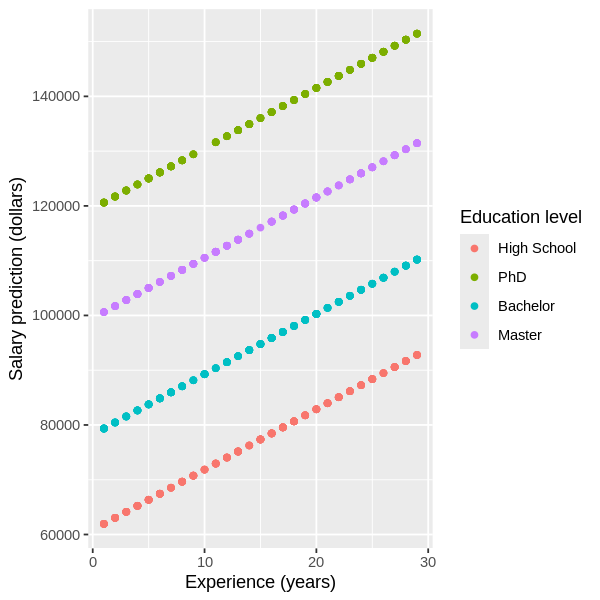

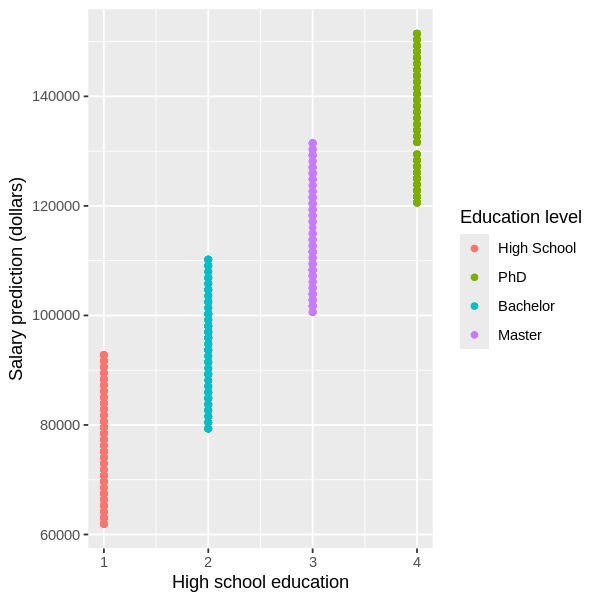

In [108]:
options(repr.plot.height = 5, repr.plot.width = 5)

exp_pred_plot <- ggplot(predictions, aes(x = experience_years, y = salary_pred, color=education)) +
  geom_point() +
  labs(x = "Experience (years)", y = "Salary prediction (dollars)", color="Education level")

exp_pred_plot


hs_pred_plot <- ggplot(predictions, aes(x = education_level, y = salary_pred, color=education)) +
  geom_point() +
  labs(x = "High school education", y = "Salary prediction (dollars)", color="Education level") +
  xlim(1, 4)

# bd_pred_plot <- ggplot(predictions, aes(x = bachelor, y = salary_pred, color=education)) +
#   geom_point() +
#   labs(x = "Bachelor education", y = "Salary prediction (dollars)", color="Education level") +
#   xlim(0, 1)

# md_pred_plot <- ggplot(predictions, aes(x = master, y = salary_pred, color=education)) +
#   geom_point() +
#   labs(x = "Masters education", y = "Salary prediction (dollars)", color="Education level") +
#   xlim(0, 1)

# phd_pred_plot <- ggplot(predictions, aes(x = phd, y = salary_pred, color=education)) +
#   geom_point() +
#   labs(x = "PhD education", y = "Salary prediction (dollars)", color="Education level") +
#   xlim(0, 1)

# facet_grid(columns=vars(hs_pred_plot, bd_pred_plot, md_pred_plot, phd_pred_plot))

hs_pred_plot

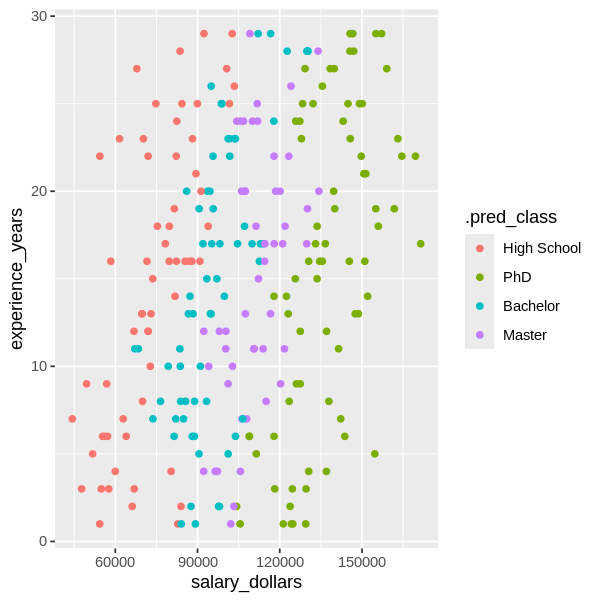

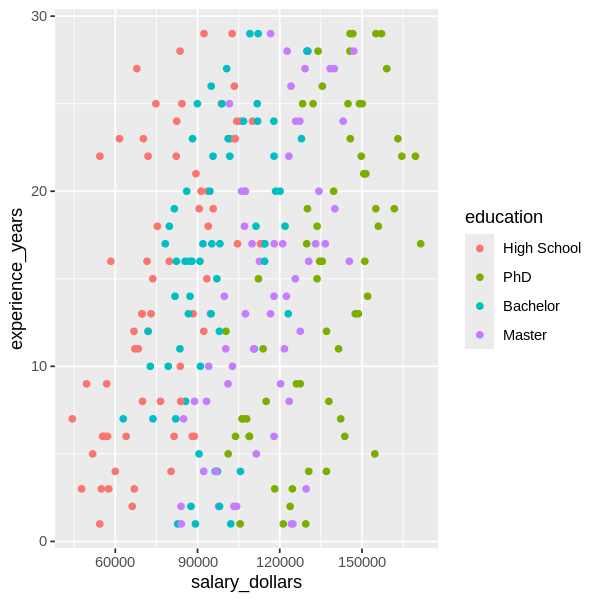

In [9]:
options(repr.plot.height = 5, repr.plot.width = 5)

pred_vis <- ggplot(salary_preds, aes(x=salary_dollars, y=experience_years)) +
    geom_point(aes(color=.pred_class))

truth_vis <- ggplot(salary_preds, aes(x=salary_dollars, y=experience_years)) +
    geom_point(aes(color=education))

pred_vis
truth_vis

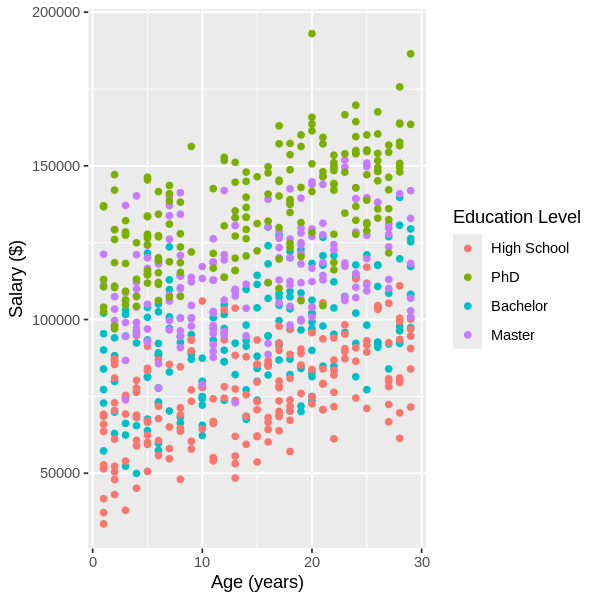

In [10]:
df_plot <- df_train |>
    ggplot(aes(x = experience_years, y = salary_dollars, color = education)) +
    geom_point() +
    labs(x = "Age (years)", y = "Salary ($)", color = "Education Level")

df_plot

## Data Summary

## Outcomes

## Impacts

## Future Questions

- low accuracy, because no relationship
- 

In [25]:
# Create dummy variables for education levels
df_untidy$phd <- as.numeric(df_untidy$Education == "PhD")
df_untidy$bachelor <- as.numeric(df_untidy$Education == "Bachelor")
df_untidy$master <- as.numeric(df_untidy$Education == "Master")
df_untidy$high_school <- as.numeric(df_untidy$Education == "High School")

# Run the linear regression
model1 <- lm(Salary ~ Experience + phd, data=df_untidy)
model2 <- lm(Salary ~ Experience + bachelor, data=df_untidy)
model3 <- lm(Salary ~ Experience + master, data=df_untidy)
model4 <- lm(Salary ~ Experience + high_school, data=df_untidy)
model5 <- lm(Salary ~ Experience + phd + bachelor + master, data=df_untidy)
#model5 <- lm(Salary ~ Experience + phd + bachelor + master + high_school, data=df_untidy) but 
# eliminate high_school due to multicollinearity and dummy variable trap

# Summarize the regression results
# summary(model1)
# summary(model2)
# summary(model3)
# summary(model4)
summary(model5)

# Predictions
#predictions <- predict(model5, data=df_untidy)
#print(predictions)


Call:
lm(formula = Salary ~ Experience + phd + bachelor + master, data = df_untidy)

Residuals:
   Min     1Q Median     3Q    Max 
-40892 -11130    -88  10407  51480 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 60836.48    1221.13   49.82   <2e-16 ***
Experience   1101.48      55.53   19.84   <2e-16 ***
phd         58670.37    1301.44   45.08   <2e-16 ***
bachelor    17414.17    1298.46   13.41   <2e-16 ***
master      38671.59    1314.47   29.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14630 on 995 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7319 
F-statistic: 682.7 on 4 and 995 DF,  p-value: < 2.2e-16


## Need to remove stuff below here.

## Methods

- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

## Expected outcomes and significance

We expect to find that higher numbers in all predictor fields (salary, years of work experience, and age) predict a higher level of education.

We wish to use our findings to help someone determine what education level, years of experience, and age they should be in order to reach a certain salary range. These results may impact the way people choose to allocate the years of their life, and hopefully help them reach a decision in a less ambiguous way.

This analysis could lead to future questions about whether or not people should be spending their time and money on higher education in order to reach their desired financial position.